✅ Columns in CSV: Index(['item name', 'store name', 'price', 'stock status', 'expiration date'], dtype='object')

📋 Sample Data:
  item name    store name  price  stock status expiration date
0    Potato        Target  71.04  Out of Stock      2026-01-10
1     Onion   Whole Foods   4.09      In Stock      2025-07-31
2     Juice        Kroger  87.15     Low Stock      2025-12-17
3     Pasta   Whole Foods  14.73     Low Stock      2025-06-02
4   Chicken  Trader Joe's  13.60     Low Stock      2025-10-10

📦 Dataset Shape: 5000 rows × 5 columns

📊 Cross-Validation F1 Score: 0.7833

✅ Final Test Accuracy: 0.9480
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       867
           1       0.95      0.65      0.77       133

    accuracy                           0.95      1000
   macro avg       0.95      0.82      0.87      1000
weighted avg       0.95      0.95      0.94      1000

📉 Confusion Matrix:
[[862   5]
 [

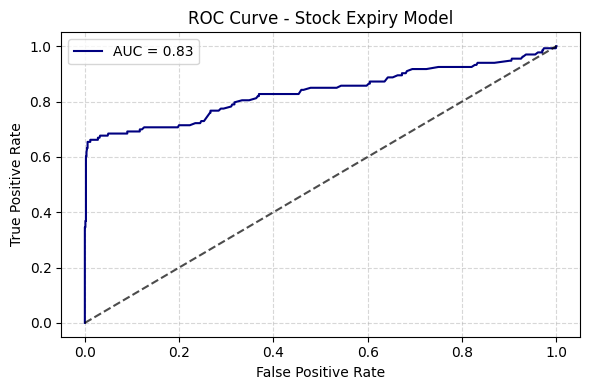

✅ Model saved as stock_expiry_alert_model.pkl


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib

# 📌 1. Load Dataset
df = pd.read_csv("uploads/training_data.csv")
df.columns = df.columns.str.lower().str.strip()

print("✅ Columns in CSV:", df.columns)
print("\n📋 Sample Data:")
print(df.head())
print(f"\n📦 Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")

# 📌 2. Detect Expiry Column
expiry_col = [col for col in df.columns if "expiry" in col or "expiration" in col]
if expiry_col:
    expiry_col = expiry_col[0]
    df["expiry_date"] = pd.to_datetime(df[expiry_col], dayfirst=True, errors="coerce")
else:
    raise ValueError("⚠️ No expiry column found.")

# 📌 3. Calculate Days to Expiry
df["days_to_expiry"] = (df["expiry_date"] - pd.Timestamp.today()).dt.days
df["days_to_expiry"] = df["days_to_expiry"].fillna(999)

# 📌 4. Generate Target Variable
df["expiring_soon"] = (df["days_to_expiry"] < 7).astype(int)

# 📌 5. Encode Stock Status
df["stock_status"] = df["stock status"].astype("category").cat.codes if "stock status" in df.columns else 0

# 📌 6. Add Controlled Noise
np.random.seed(42)

# Label noise: Flip 5% of the labels randomly
flip_indices = df.sample(frac=0.05).index
df.loc[flip_indices, "expiring_soon"] = 1 - df.loc[flip_indices, "expiring_soon"]

# Feature noise: Add Gaussian noise to numeric columns
df["price"] += np.random.normal(0, 1.5, df.shape[0])  # small noise
df["days_to_expiry"] += np.random.normal(0, 2, df.shape[0])

# 📌 7. Define Features and Target
X = df[["days_to_expiry", "stock_status", "price"]]
y = df["expiring_soon"]

# 📌 8. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 📌 9. Improved Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="f1",  # better for imbalanced classification
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
model_expiry = grid_search.best_estimator_

# 📌 10. Cross-Validation Score (F1)
cv_scores = cross_val_score(model_expiry, X_train, y_train, cv=5, scoring="f1")
print(f"\n📊 Cross-Validation F1 Score: {np.mean(cv_scores):.4f}")

# 📌 11. Test Set Evaluation
y_pred = model_expiry.predict(X_test)
y_prob = model_expiry.predict_proba(X_test)[:, 1]

print(f"\n✅ Final Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"🎯 ROC-AUC Score: {roc_auc:.4f}")

# 📈 12. Optional ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='navy')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stock Expiry Model")
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 📌 13. Save Model
joblib.dump(model_expiry, "models/stock_expiry_alert_model.pkl")
print("✅ Model saved as stock_expiry_alert_model.pkl")


c:\Users\narap\Downloads\groc_project_new\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


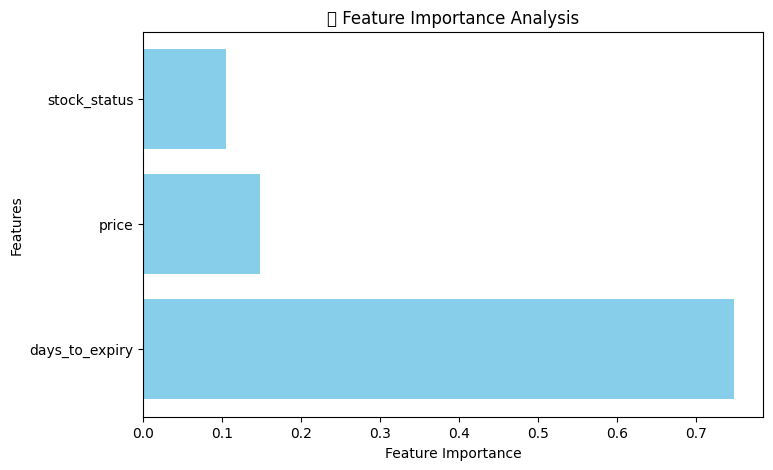

In [5]:
# 📌 Check Feature Importance
importances = model_expiry.feature_importances_
features = X.columns

# Sort & Plot
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 5))
plt.barh([features[i] for i in sorted_idx], importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("🔍 Feature Importance Analysis")
plt.show()


In [1]:
# %%
# Widget for file upload
from IPython.display import display
import ipywidgets as widgets

uploader = widgets.FileUpload(
    accept='.csv',
    multiple=False,
    description='Upload CSV'
)
display(uploader)

# %%
# Read uploaded file
import io
import pandas as pd

def process_uploaded_file(uploader):
    if not uploader.value:
        print("Please upload a CSV file first")
        return None
    
    uploaded_filename = next(iter(uploader.value))
    content = uploader.value[uploaded_filename]['content']
    return pd.read_csv(io.BytesIO(content))

df = process_uploaded_file(uploader)
if df is not None:
    display(df.head())

# %%
# Data Preparation
if df is not None:
    # Check for required columns
    required_cols = {'Price', 'Stock Status'}
    expiry_cols = [col for col in df.columns if "expiry" in col.lower() or "expiration" in col.lower()]
    
    if not required_cols.issubset(df.columns) or not expiry_cols:
        print(f"Error: CSV must contain Price, Stock Status, and an expiry date column")
    else:
        # Process expiry date
        expiry_col = expiry_cols[0]
        df["expiry_date"] = pd.to_datetime(df[expiry_col], dayfirst=True, errors="coerce")
        
        # Calculate days to expiry
        df["days_to_expiry"] = (df["expiry_date"] - pd.Timestamp.today()).dt.days
        df["days_to_expiry"] = df["days_to_expiry"].fillna(999)  # Handle missing dates
        
        # Create target
        df["expiring_soon"] = (df["days_to_expiry"] < 7).astype(int)
        
        # Encode categorical
        df["stock_status"] = df["Stock Status"].astype("category").cat.codes
        
        # Show prepared data
        display(df.head())

# %%
# Model Training (only if data preparation succeeded)
if 'df' in locals() and df is not None and required_cols.issubset(df.columns) and 'expiry_date' in df.columns:
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, classification_report
    
    X = df[["days_to_expiry", "stock_status", "Price"]]
    y = df["expiring_soon"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [5, 10, 15],
    }
    
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
    # Evaluate
    y_pred = best_model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(classification_report(y_test, y_pred))
    
    # Save model
    import joblib
    import os
    
    os.makedirs("models", exist_ok=True)
    model_path = "models/stock_expiry_alert_model.pkl"
    joblib.dump(best_model, model_path)
    print(f"Model saved to {model_path}")

# %%
# Make Prediction (if model exists)
if 'model_path' in locals():
    try:
        loaded_model = joblib.load(model_path)
        sample_data = pd.DataFrame([[5, 1, 10.99]], 
                                 columns=["days_to_expiry", "stock_status", "Price"])
        prediction = loaded_model.predict(sample_data)[0]
        print(f"Expiring soon prediction (1=yes, 0=no): {prediction}")
    except Exception as e:
        print(f"Error making prediction: {e}")

FileUpload(value=(), accept='.csv', description='Upload CSV')

Please upload a CSV file first
